In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import kerastuner as kt
from kerastuner import HyperModel, RandomSearch, BayesianOptimization, Hyperband

physical_devices_CPU = tf.config.list_physical_devices('CPU') 


print('Running TensorFlow', tf.__version__)
print('Running KerasTuner', kt.__version__)
print('CPUs Available:', len(physical_devices_CPU))


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

import random as rn
seed = 6
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Plot styles
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams["font.family"] = 'DejaVu Sans'
plt.rcParams["font.size"] = '12'
plt.rcParams['image.cmap'] = 'rainbow'

Running TensorFlow 2.17.0
Running KerasTuner 1.0.5
CPUs Available: 1


In [3]:
dataset = pd.read_csv('Concrete_Data .csv')
print(dataset.head(), '\n')
print('Shape of data set:', dataset.shape)

   cement   slag  flyash  water  superplas  coarse_agg  fine_agg  age  \
0   540.0    0.0     0.0  162.0        2.5      1040.0     676.0   28   
1   540.0    0.0     0.0  162.0        2.5      1055.0     676.0   28   
2   332.5  142.5     0.0  228.0        0.0       932.0     594.0  270   
3   332.5  142.5     0.0  228.0        0.0       932.0     594.0  365   
4   198.6  132.4     0.0  192.0        0.0       978.4     825.5  360   

   strength  
0     79.99  
1     61.89  
2     40.27  
3     41.05  
4     44.30   

Shape of data set: (1030, 9)


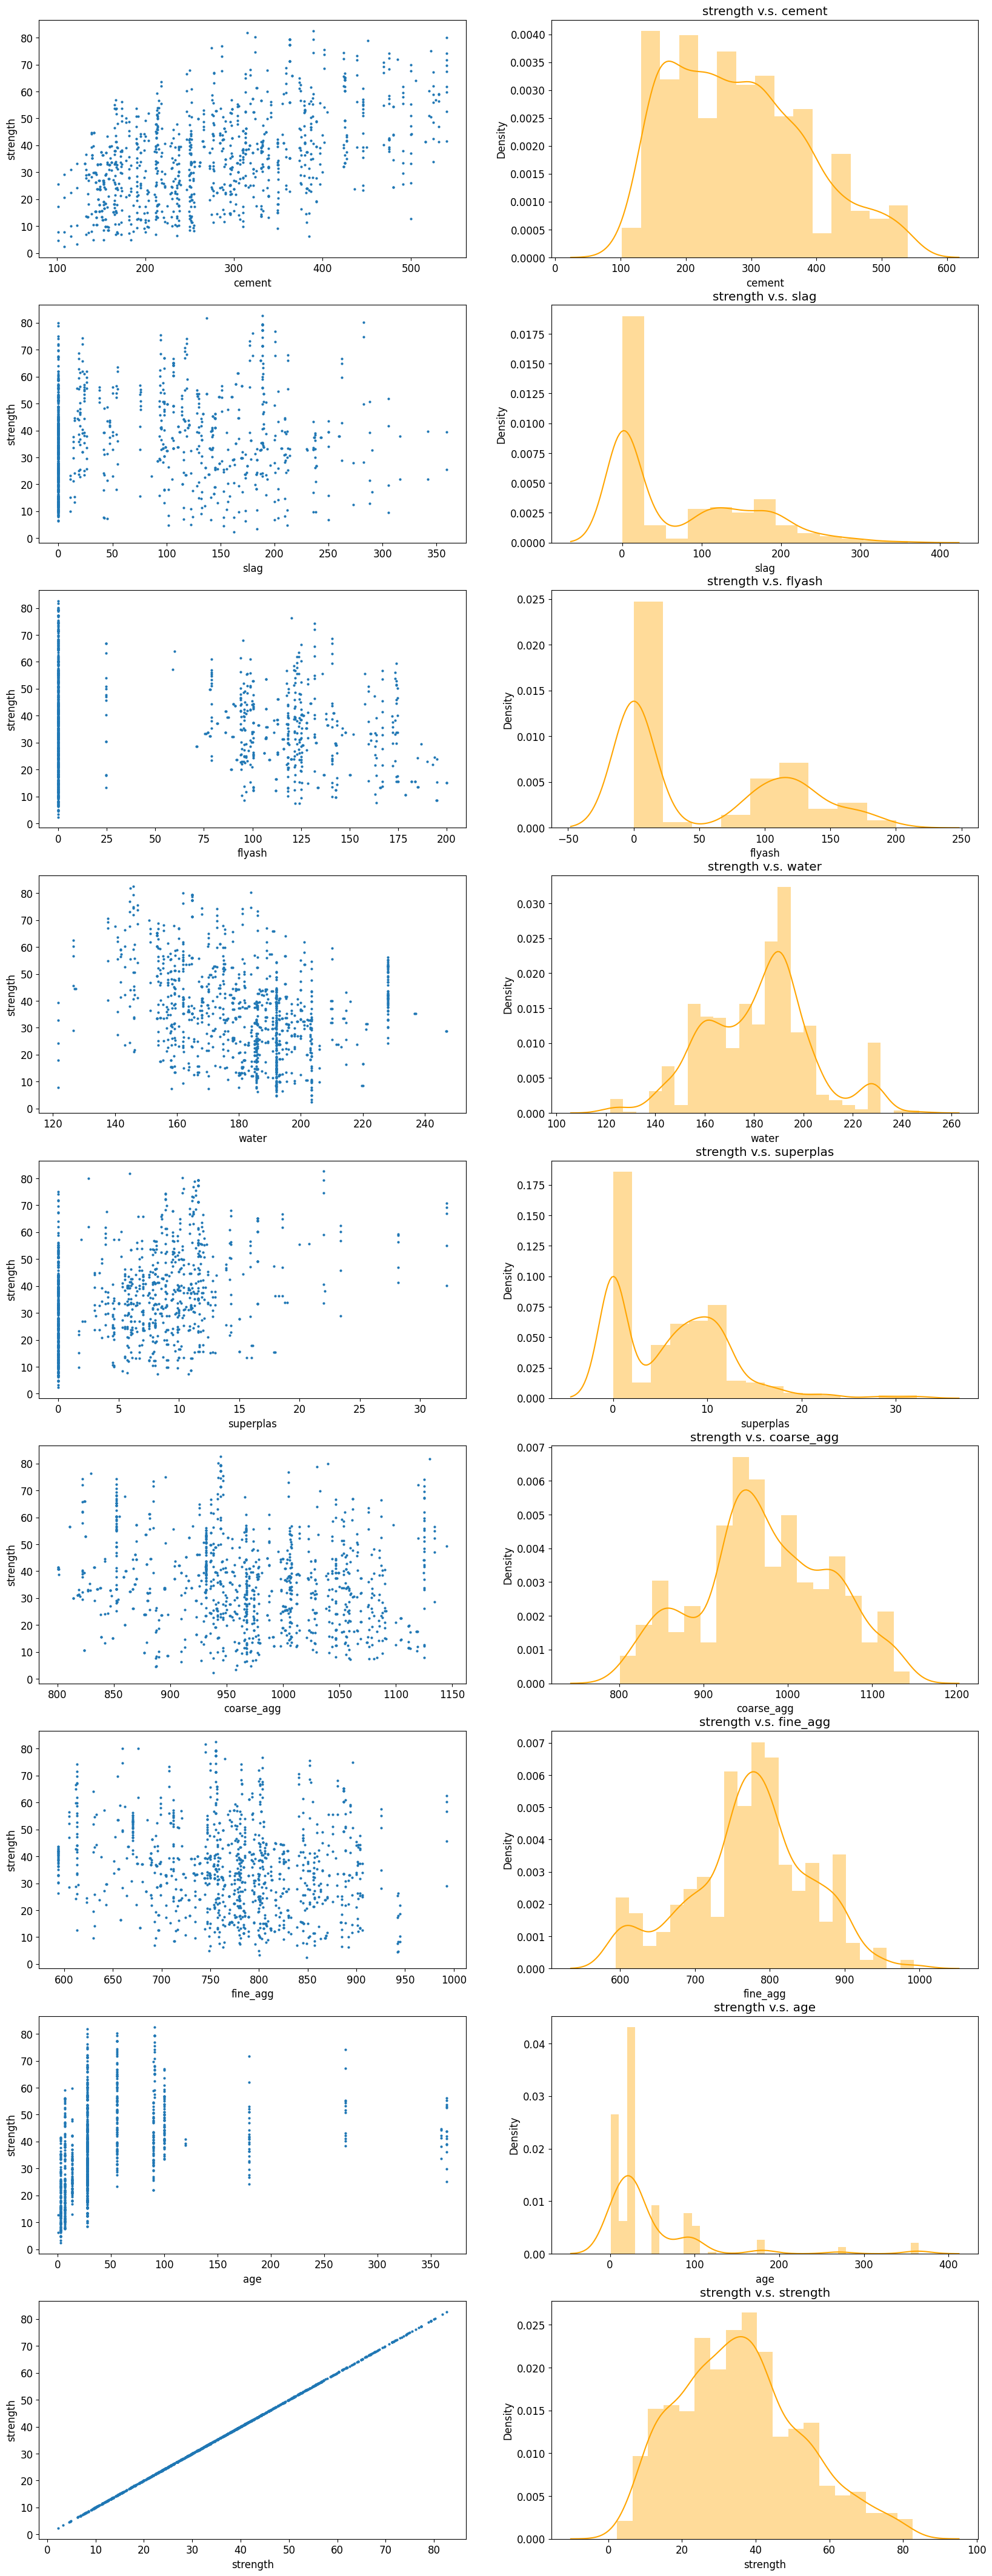

In [3]:
keys = [f for f in dataset.columns]

fig, ax = plt.subplots(len(keys),2,figsize=(20,len(keys)*6))

for n in range(len(keys)):
    feat = keys[n]
    title = 'strength v.s. ' + f'{feat}'
    ax[n,0].scatter(dataset[feat].values, dataset.strength.values, s=4)
    ax[n,0].set_ylabel('strength')
    ax[n,0].set_xlabel(feat)
    sns.distplot(dataset[feat].dropna(), kde=True, ax=ax[n,1], color='orange')
    ax[n,1].set_title(title)

<function matplotlib.pyplot.show(close=None, block=None)>

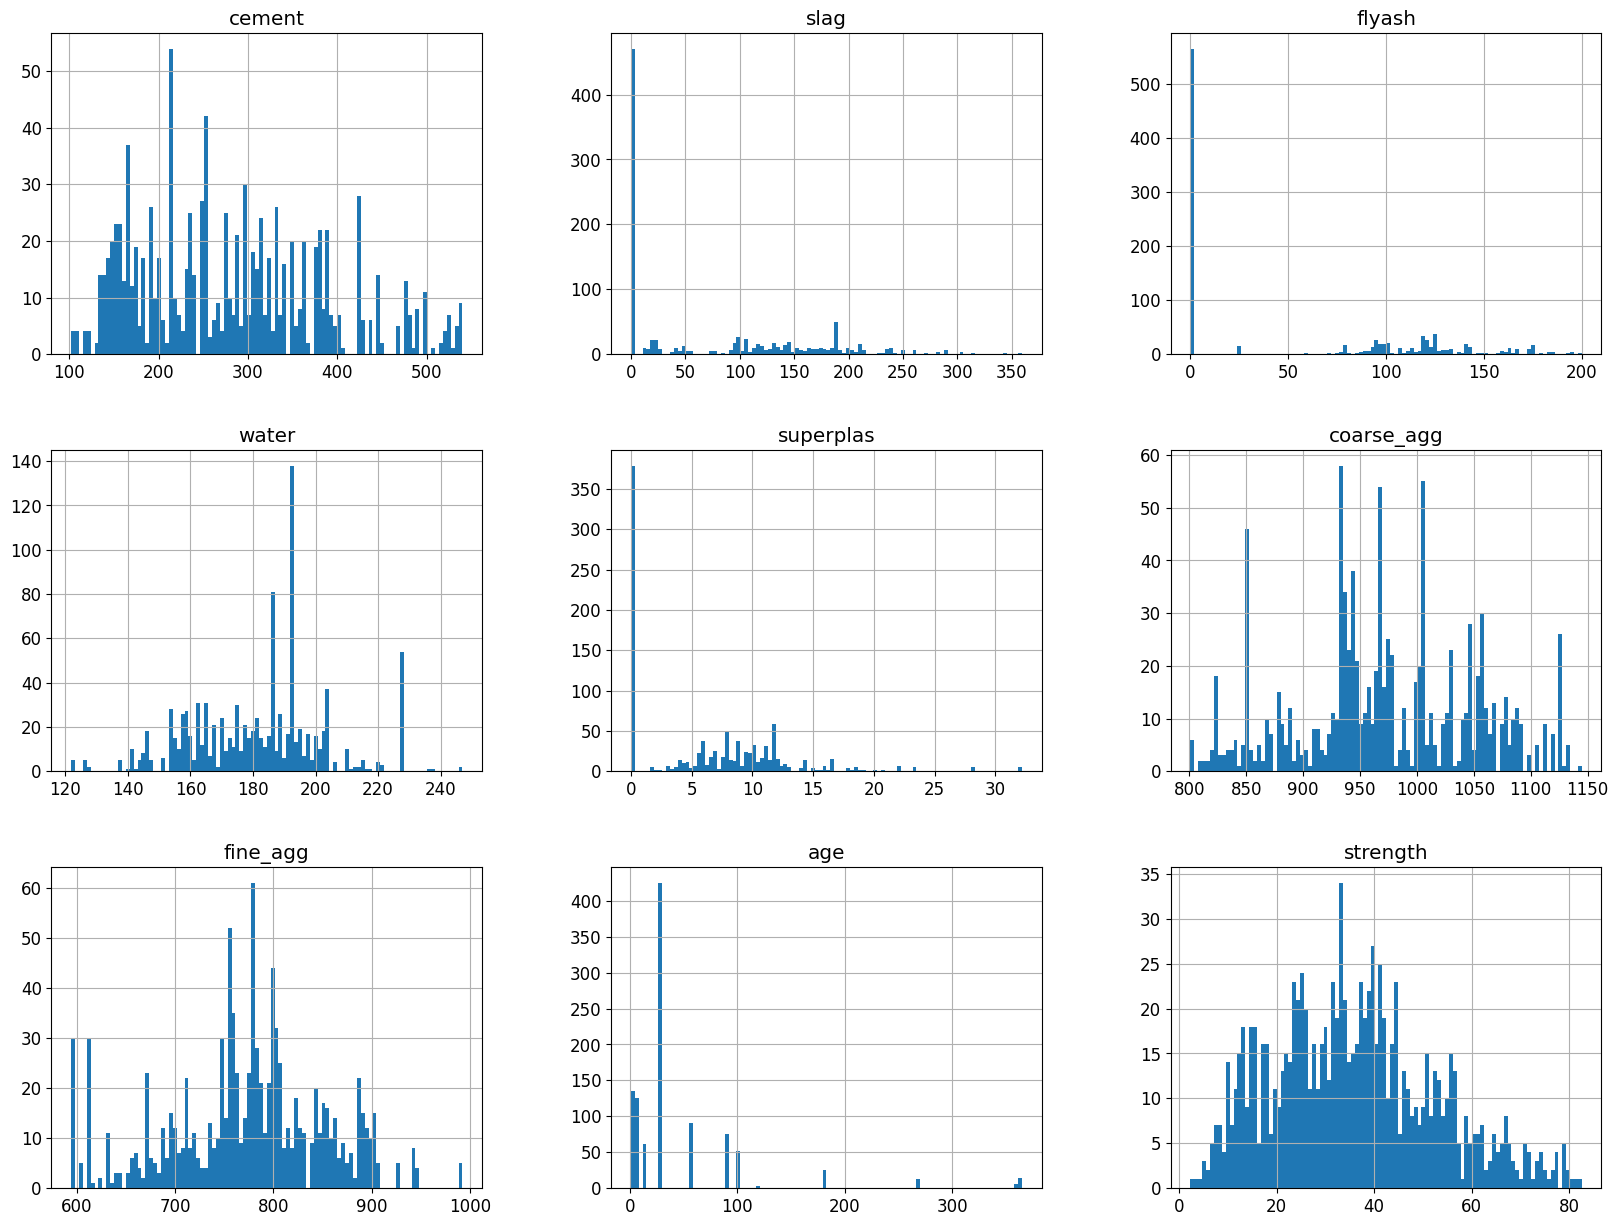

In [4]:
dataset.hist(bins=100, figsize=(20, 15))
plt.show

<Axes: >

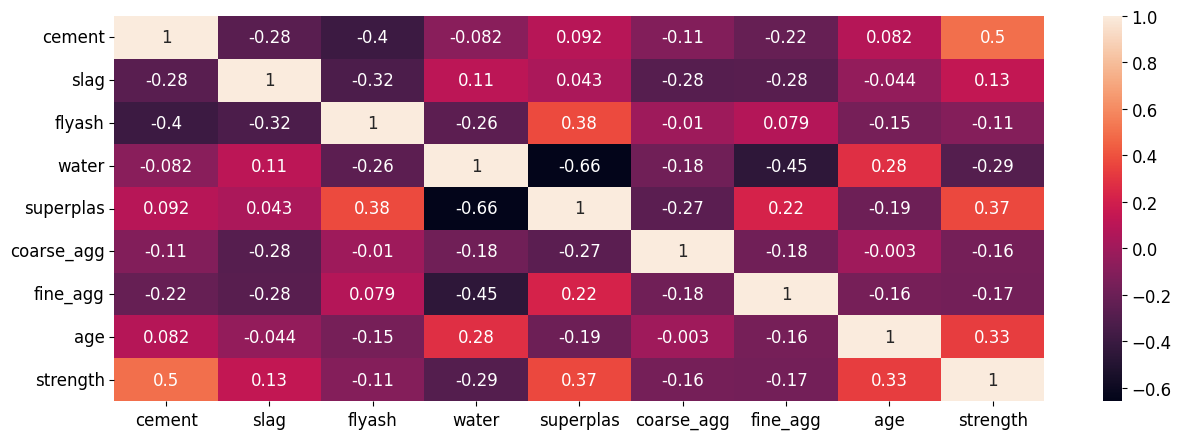

In [5]:
import seaborn as sns
sns.heatmap(dataset.corr(), annot = True)

In [4]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(dataset)
normal = normal.apply(test_normality)
print('Is dataset normal?',  normal.any())

Is dataset normal? True


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=69) # Take 80% of dataset for training.
test_dataset = dataset.drop(train_dataset.index) 
print('Training dataset shape:', train_dataset.shape)
print('Testing dataset shape:', test_dataset.shape)

NameError: name 'dataset' is not defined

In [6]:
train_stats = train_dataset.describe()
train_stats.pop('strength') 
train_stats = train_stats.transpose() 
train_stats

,count,mean,std,min,25%,50%,75%,max
cement,824.0,281.377306,104.495567,102.0,194.4,269.40,351.250,540.0
slag,824.0,73.903277,86.092338,0.0,0.0,22.00,142.500,359.4
flyash,824.0,53.997937,63.164905,0.0,0.0,0.00,118.300,195.0
water,824.0,181.990413,21.217147,121.8,164.9,185.70,192.000,247.0
superplas,824.0,6.206311,6.001590,0.0,0.0,6.35,10.325,32.2
coarse_agg,824.0,972.764320,78.171931,801.0,932.0,968.00,1030.000,1145.0
fine_agg,824.0,773.141262,80.462484,594.0,724.3,780.10,824.250,992.6
age,824.0,44.993932,62.216931,1.0,7.0,28.00,56.000,365.0


In [7]:
train_labels = train_dataset.pop('strength') # Separate strength from dataset to train network.
test_labels = test_dataset.pop('strength') # Separate strength from dataset to test after training.

print('Training labels have shape:', train_labels.shape)
print('Testing labels have shape:', test_labels.shape)

Training labels have shape: (824,)
Testing labels have shape: (206,)


     cement      slag    flyash     water  superplas  coarse_agg  fine_agg  \
0 -0.290939  1.223851 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   
1 -0.460313 -1.068428  1.044005  0.361426   0.082675   -0.075890  1.238969   
2  0.972858  1.023526 -0.912456 -1.339689   1.310373    2.077535 -1.961713   
3  1.071115 -1.068428 -0.912456  0.486578  -1.221546   -0.414423  0.113932   
4 -0.136537 -1.068428 -0.912456  0.207646  -1.221546    1.775726  0.093599   

        age  
0  2.417297  
1 -1.665705  
2  0.122103  
3 -1.040709  
4 -1.040709  


<Axes: xlabel='cement', ylabel='Density'>

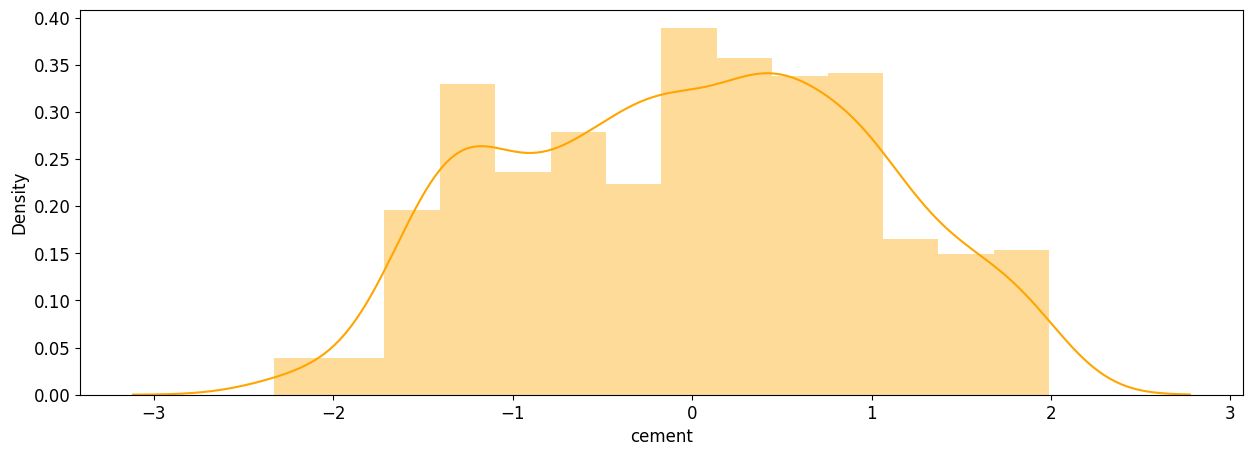

In [8]:
# Apply Power Transformation first
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer()
transformed_train_data = pd.DataFrame(transformer.fit_transform(train_dataset), columns=train_dataset.columns)
transformed_test_data = pd.DataFrame(transformer.transform(test_dataset), columns=test_dataset.columns)

train_stats = transformed_train_data.describe().transpose()

def standardise(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = standardise(transformed_train_data)

normed_test_data = standardise(transformed_test_data)

print(normed_train_data.head())
sns.distplot(normed_train_data['cement'], kde=True, color='orange')


In [30]:
from scipy import stats
import numpy as np
z_scores = np.abs(stats.zscore(train_dataset))  
outliers = (z_scores > 3)
cleaned_train_data = train_dataset[(~outliers).all(axis=1)]

print(f"Shape after removing outliers using Z-score: {cleaned_train_data.shape}")


Shape after removing outliers using Z-score: (785, 8)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 11,969 (46.75 KB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1591.7960 - mae: 36.2383 - mse: 1591.0819 - val_loss: 1364.9161 - val_mae: 33.7886 - val_mse: 1364.2006
Epoch 2/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1515.3816 - mae: 35.8941 - mse: 1514.6656 - val_loss: 1353.1991 - val_mae: 33.7742 - val_mse: 1352.4813
Epoch 3/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1464.4821 - mae: 35.7446 - mse: 1463.7637 - val_loss: 1339.6091 - val_mae: 33.7736 - val_mse: 1338.8892
Epoch 4/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1427.3558 - mae: 35.5156 - mse: 1426.6356 - val_loss: 1321.2253 - val_mae: 33.7286 - val_mse: 1320.5035
Epoch 5/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1385.9374 - mae: 35.2727 - mse: 1385.2155 - val_loss: 1297.9886 - val_mae: 33.6320 - val_mse: 1297.2655
Epoch 6/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1326.1434 - mae: 34.7505 - mse: 1325.4199 - val_loss: 1264.5710 - val_mae: 33.3891 - val_mse: 1263.8461
Epoch 7/512
21/

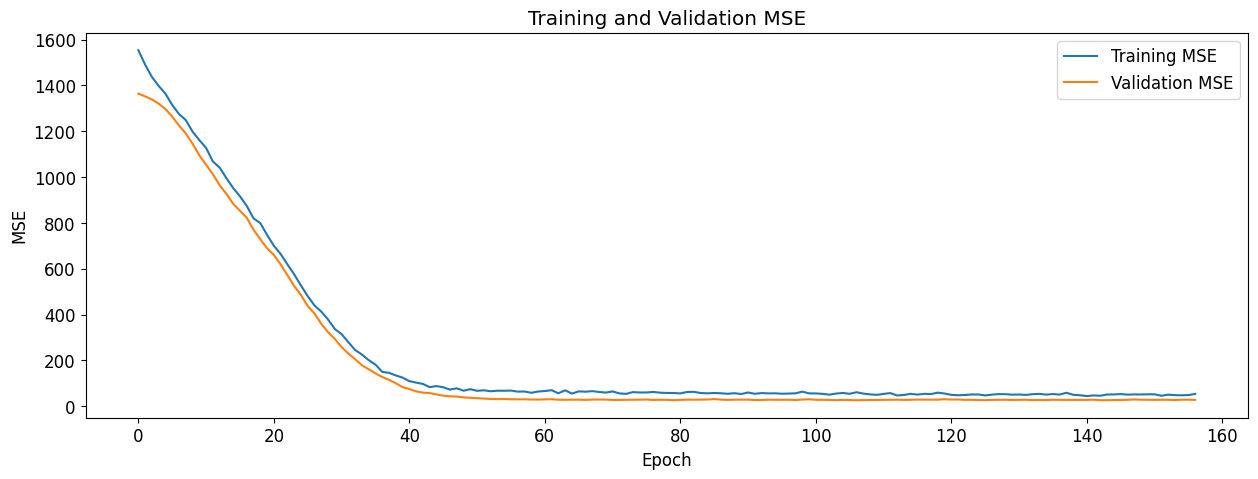

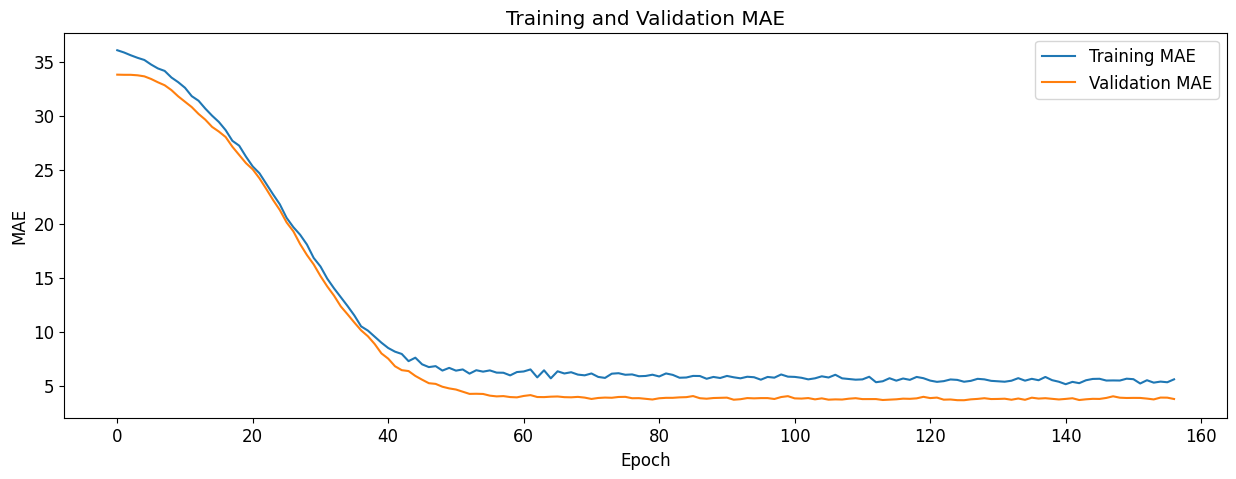

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming normed_train_data and train_labels are already defined as in your provided code

# Define the DNN model
def create_dnn_model():
    model = keras.models.Sequential()
    # Input layer and first hidden layer
    model.add(layers.Dense(64, activation='relu', input_shape=(8,), kernel_regularizer=regularizers.l2(0.01)))
    
    # Second hidden layer
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    
    # Third hidden layer
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    
    # Output layer
    model.add(layers.Dense(1, activation='linear'))  # Linear activation for output
    
    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
    
    return model

# Create the model
dnn_model = create_dnn_model()

# Print model summary
print(dnn_model.summary())

# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=60)  # Early stopping
training_stats = dnn_model.fit(normed_train_data, train_labels, 
                                batch_size=32, epochs=512, 
                                validation_split=0.2, 
                                verbose=1, callbacks=[early_stop])

# Evaluate the model
loss, mae, mse = dnn_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Test set MSE (Mean Squared Error): {:5.2f}'.format(mse))  # Print MSE
print('Test set MAE (Mean Absolute Error): {:5.2f} MPa'.format(mae))  # Print MAE

# Visualizing Training History
hist = pd.DataFrame(training_stats.history)
hist['epoch'] = training_stats.epoch

# Plot MSE
plt.plot(hist['epoch'], hist['mse'], label='Training MSE')
plt.plot(hist['epoch'], hist['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Plot MAE
plt.plot(hist['epoch'], hist['mae'], label='Training MAE')
plt.plot(hist['epoch'], hist['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [11]:
pip install keras-tuner


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
from sklearn.metrics import r2_score
test_predictions = dnn_model.predict(normed_test_data).flatten()

# Calculate the R² score
r2 = r2_score(test_labels, test_predictions)

print(f"R² Score: {r2:.4f}")
loss, mae, mse = dnn_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Test set MSE (Mean Squared Error): {:5.2f}'.format(mse))  # Print MSE
print('Test set MAE (Mean Absolute Error): {:5.2f} MPa'.format(mae)) 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R² Score: 0.8927
Test set MSE (Mean Squared Error): 33.24
Test set MAE (Mean Absolute Error):  3.66 MPa


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


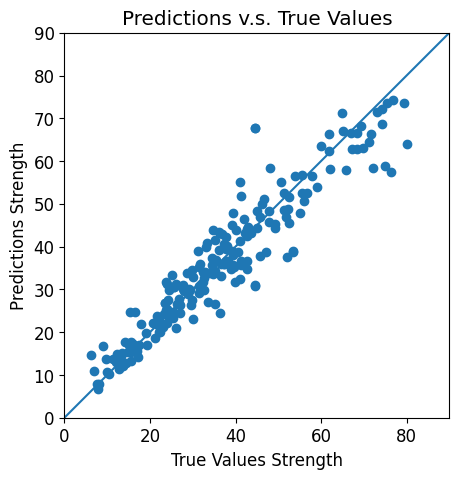

In [54]:
test_predictions = dnn_model.predict(normed_test_data).flatten() # Call dnn_model.predict() to see predictions
# Plot predictions against true values
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Strength')
plt.ylabel('Predictions Strength')
plt.title('Predictions v.s. True Values')
lims = [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

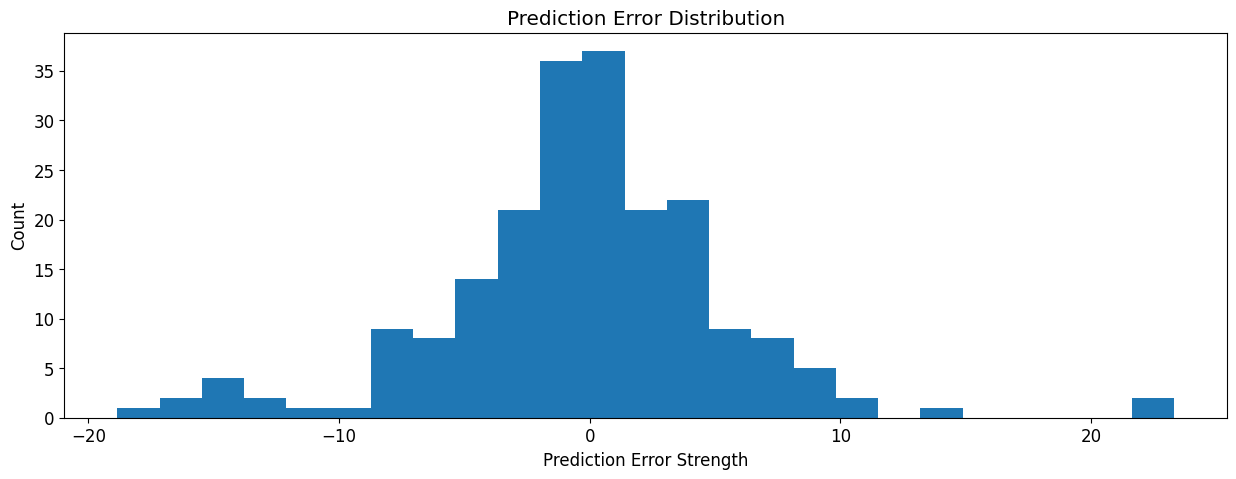

In [55]:
error = test_predictions - test_labels # error is calculated by subtracting prediction values from true values
plt.hist(error, bins = 25)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error Strength')
_ = plt.ylabel('Count')

In [28]:
!pip install hyperopt


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import numpy as np

# Define the search space for hyperparameters
space = {
    'units': hp.choice('units', [128, 256, 512]),  # Number of units in hidden layers
    'dropout': hp.uniform('dropout', 0.2, 0.5),  # Dropout rate between 0.2 and 0.5
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),  # Learning rate log scale
    'activation': hp.choice('activation', ['relu', 'tanh', 'sigmoid']),  # Activation function
    'batch_size': hp.choice('batch_size', [16, 32, 64])  # Batch size
}

# Define the objective function
def objective(params):
    # Build the model using the hyperparameters from 'params'
    model = tf.keras.Sequential()
    model.add(layers.Dense(params['units'], activation=params['activation'],
                           input_shape=(normed_train_data.shape[1],),
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(params['dropout']))
    model.add(layers.Dense(params['units'], activation=params['activation'],
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(params['dropout']))
    model.add(layers.Dense(1))  # Output layer

    # Compile the model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

    # Train the model
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(normed_train_data, train_labels,
                        batch_size=params['batch_size'],
                        epochs=100,
                        validation_split=0.2,
                        verbose=0,
                        callbacks=[early_stop])

    # Evaluate the model on validation data (to minimize MSE)
    val_loss, val_mae, val_mse = model.evaluate(normed_test_data, test_labels, verbose=0)

    return {'loss': val_mse, 'status': STATUS_OK}

# Trials object to track the hyperparameter search process
trials = Trials()

# Run the optimization
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  # Number of trials
            trials=trials)

# Display the best hyperparameters found
print("Best hyperparameters found: ", best)


100%|██████████| 50/50 [11:29<00:00, 13.79s/trial, best loss: 31.97947883605957] 
Best hyperparameters found:  {'activation': 0, 'batch_size': 0, 'dropout': 0.24309467176572233, 'learning_rate': 0.000937003284453242, 'units': 2}


In [41]:
# Final model with the best hyperparameters
model = tf.keras.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(normed_train_data.shape[1],),
                       kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.2430))  # Dropout
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.2430))  # Dropout
model.add(layers.Dense(1))  # Output layer

# Compile with the optimized learning rate
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000937)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
history = model.fit(normed_train_data, train_labels,
                    batch_size=16,
                    epochs=150,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

# Evaluate the final model on the test set
test_loss, test_mae, test_mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print(f'Test set MSE: {test_mse:.4f}')
print(f'Test set MAE: {test_mae:.4f} MPa')


Epoch 1/150
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1330.8969 - mae: 32.0645 - mse: 1325.5717 - val_loss: 500.1812 - val_mae: 18.2999 - val_mse: 494.5185
Epoch 2/150
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 430.5449 - mae: 16.3940 - mse: 424.7640 - val_loss: 131.8070 - val_mae: 9.0605 - val_mse: 125.8906
Epoch 3/150
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 136.7244 - mae: 9.1909 - mse: 130.8974 - val_loss: 95.5852 - val_mae: 7.5525 - val_mse: 90.0535
Epoch 4/150
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 105.8174 - mae: 7.8138 - mse: 100.3631 - val_loss: 82.7749 - val_mae: 6.9193 - val_mse: 77.5044
Epoch 5/150
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.2715 - mae: 7.2258 - mse: 89.0532 - val_loss: 76.1881 - val_mae: 6.5667 - val_mse: 71.0626
Epoch 6/150
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 84.7811 - mae: 6.7297 - mse: 79.6868 - val_loss: 70.9002 - val_mae: 6.2779 - val_mse: 65.8496
Epoch 7/150
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 74.01

In [42]:
print(f'Test set MSE: {test_mse:.4f}')
print(f'Test set MAE: {test_mae:.4f} MPa')

Test set MSE: 28.3811
Test set MAE: 3.8208 MPa


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


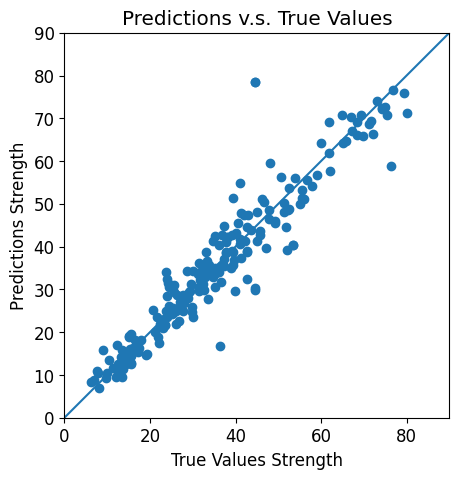

In [65]:
test_predictions = dnn_model.predict(normed_test_data).flatten() 
# Plot predictions against true values
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Strength')
plt.ylabel('Predictions Strength')
plt.title('Predictions v.s. True Values')

plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [71]:
from sklearn.model_selection import KFold

# Cross-validation setup to evaluate stability
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

fold_scores = []

for train_index, val_index in kf.split(normed_train_data):
    X_train, X_val = normed_train_data.iloc[train_index], normed_train_data.iloc[val_index]
    y_train, y_val = train_labels.iloc[train_index], train_labels.iloc[val_index]
    
    model = create_dnn_model()
    model.fit(X_train, y_train, epochs=100, verbose=1)
    
    val_mse = model.evaluate(X_val, y_val, verbose=1)[2]
    fold_scores.append(val_mse)

print(f"Cross-Validation MSE Scores: {fold_scores}")
print(f"Mean MSE: {np.mean(fold_scores):.4f}")


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1463.6285 - mae: 34.7907 - mse: 1462.8564
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1356.2874 - mae: 33.2487 - mse: 1355.5037 
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1120.2094 - mae: 29.6675 - mse: 1119.3789 
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 655.6995 - mae: 21.4843 - mse: 654.7800
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 212.4100 - mae: 11.3203 - mse: 211.3767
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 129.4151 - mae: 8.9448 - mse: 128.3286
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.2514 - mae: 7.9093 - mse: 101.1789
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 91.4676 - mae: 7.4440 - mse: 90.4004
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85.4765 - mae: 7.1701 - mse: 84.4130
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80.7124 - mae: 6.9597 - mse: 79.6534
Epoch 11/100

In [26]:
import shap
print(shap.__version__)

0.46.0


In [27]:
# Normalized training and test data
explainer = shap.Explainer(dnn_model, normed_train_data)
shap_values = explainer(normed_test_data)

ExactExplainer explainer: 207it [00:34,  5.78it/s]                         


In [29]:
print('SHAP values shape:', np.shape(shap_values))
print('Test data shape:', np.shape(normed_test_data))



SHAP values shape: (206, 8)
Test data shape: (206, 8)


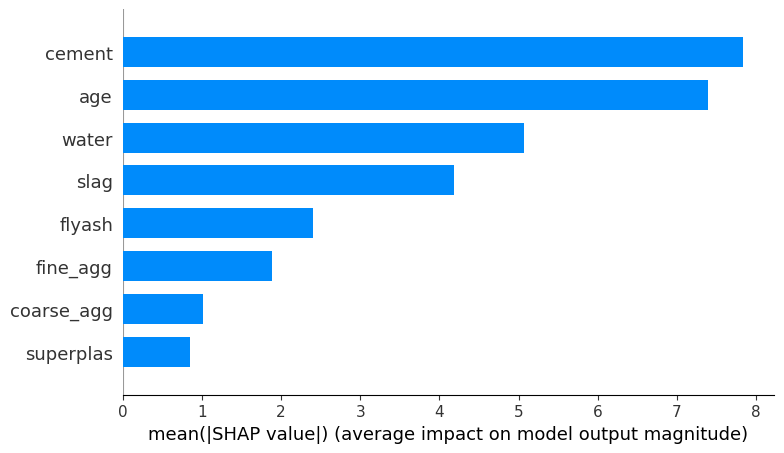

In [30]:
# Visualize the SHAP values
shap.summary_plot(shap_values, normed_train_data, plot_type="bar")

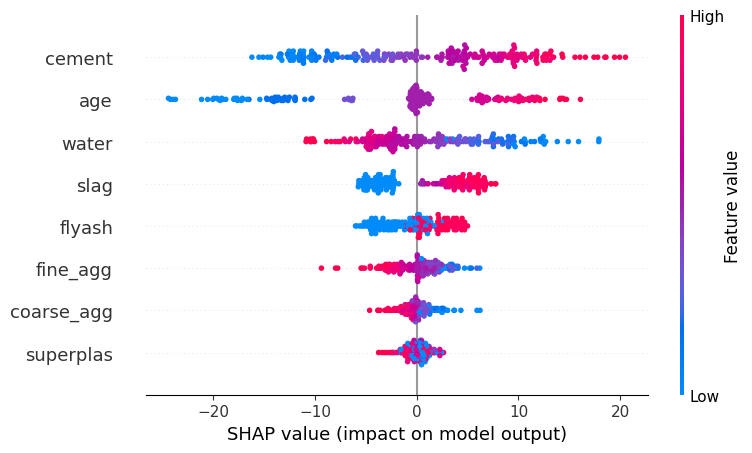

In [31]:
shap.summary_plot(shap_values, normed_test_data)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 824 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/206 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 6s 885us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 799us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 794us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 807us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 791us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 790us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 768us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 790us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 771us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 760us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 5s 787us/step
1/1 ━━

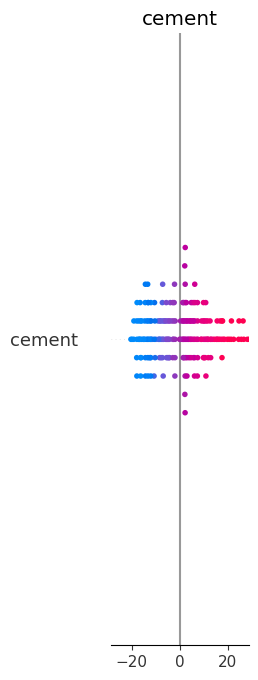

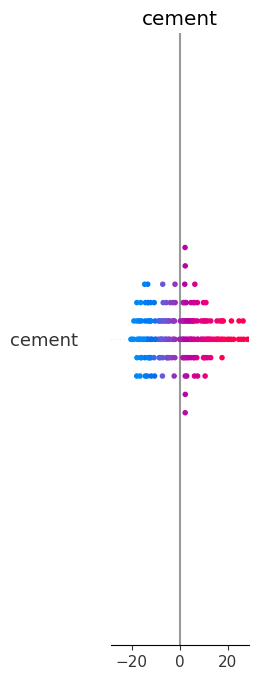

In [45]:
import shap
import numpy as np

# Create a SHAP explainer with KernelExplainer for the DNN model
explainer = shap.KernelExplainer(dnn_model.predict, normed_train_data)
shap_values = explainer.shap_values(normed_test_data)
print('SHAP values shape:', np.shape(shap_values)) 
print('Test data shape:', np.shape(normed_test_data)) 

if isinstance(shap_values, list):
    for i, shap_value in enumerate(shap_values):
        print(f"SHAP values shape for output {i}: {np.shape(shap_value)}")
else:
    print(f"SHAP values shape: {np.shape(shap_values)}")
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[0], normed_test_data, plot_type="bar")  # First output's SHAP values
    shap.summary_plot(shap_values[0], normed_test_data)  # Summary plot for first output
else:
    shap.summary_plot(shap_values, normed_test_data, plot_type="bar")
    shap.summary_plot(shap_values, normed_test_data)


Instance 1: Feature with highest SHAP value: cement, SHAP value: 21.8845
Instance 2: Feature with highest SHAP value: cement, SHAP value: 22.9770
Instance 3: Feature with highest SHAP value: cement, SHAP value: 13.1936
Instance 4: Feature with highest SHAP value: fine_agg, SHAP value: 11.1989
Instance 5: Feature with highest SHAP value: slag, SHAP value: 13.3204
Instance 6: Feature with highest SHAP value: age, SHAP value: 8.1879
Instance 7: Feature with highest SHAP value: age, SHAP value: 12.6411
Instance 8: Feature with highest SHAP value: cement, SHAP value: 23.2128
Instance 9: Feature with highest SHAP value: cement, SHAP value: 27.5086
Instance 10: Feature with highest SHAP value: age, SHAP value: 25.2830
Instance 11: Feature with highest SHAP value: age, SHAP value: 25.1052
Instance 12: Feature with highest SHAP value: age, SHAP value: 26.1696
Instance 13: Feature with highest SHAP value: cement, SHAP value: 13.7957
Instance 14: Feature with highest SHAP value: slag, SHAP value:

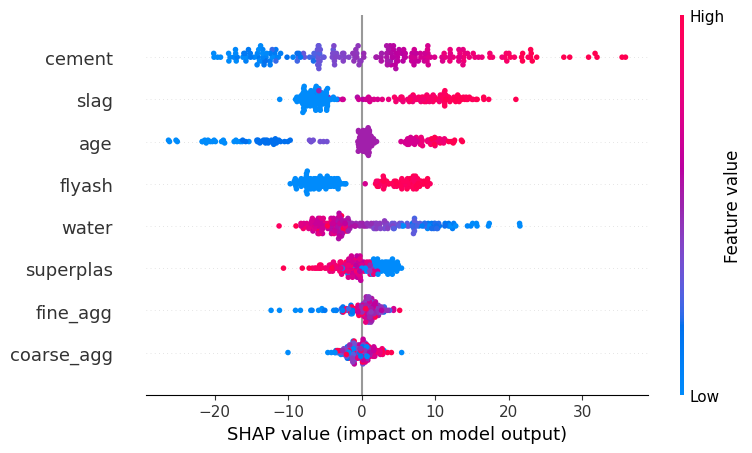

In [44]:
import shap
import numpy as np

shap_values_array = shap_values.values 
max_shap_values = np.max(np.abs(shap_values_array), axis=1)

# Find the index of the feature with the maximum absolute SHAP value per instance
max_shap_feature_index = np.argmax(np.abs(shap_values_array), axis=1)

# Print the feature name that has the highest SHAP value for each instance
for i in range(len(max_shap_feature_index)):
    feature_name = normed_test_data.columns[max_shap_feature_index[i]]
    print(f"Instance {i+1}: Feature with highest SHAP value: {feature_name}, SHAP value: {max_shap_values[i]:.4f}")

# Optional: Visualize the SHAP summary plot as before
shap.summary_plot(shap_values, normed_test_data)


In [41]:
import shap
import numpy as np
shap_values_array = shap_values.values
overall_max_shap_value = np.max(np.abs(shap_values_array))
max_shap_feature_index = np.unravel_index(np.argmax(np.abs(shap_values_array)), shap_values_array.shape)

# Get the feature name with the highest SHAP value
feature_name = normed_test_data.columns[max_shap_feature_index[1]]  # Use index 1 for feature axis

# Print the results
print(f"Feature with the highest SHAP value: {feature_name}")
print(f"Highest SHAP value: {overall_max_shap_value:.4f}")


Feature with the highest SHAP value: cement
Highest SHAP value: 30.8106


In [42]:
import shap
import numpy as np
import pandas as pd
shap_values_array = shap_values.values  # Extract SHAP values correctly
feature_names = normed_test_data.columns  # Get the feature names from test data

# Create a DataFrame for SHAP values for better readability
shap_df = pd.DataFrame(shap_values_array, columns=feature_names)

# Print SHAP values for every feature
for i, row in shap_df.iterrows():
    print(f"Instance {i+1}:")
    for feature, value in row.items():
        print(f"  Feature: {feature} -> SHAP Value: {value:.4f}")
    print("\n")


Instance 1:
  Feature: cement -> SHAP Value: 19.6048
  Feature: slag -> SHAP Value: -5.1352
  Feature: flyash -> SHAP Value: -5.9384
  Feature: water -> SHAP Value: -8.0321
  Feature: superplas -> SHAP Value: 3.0277
  Feature: coarse_agg -> SHAP Value: 0.6408
  Feature: fine_agg -> SHAP Value: -2.1355
  Feature: age -> SHAP Value: 0.6531


Instance 2:
  Feature: cement -> SHAP Value: 19.0418
  Feature: slag -> SHAP Value: -4.8116
  Feature: flyash -> SHAP Value: -6.1756
  Feature: water -> SHAP Value: -8.8299
  Feature: superplas -> SHAP Value: 2.8336
  Feature: coarse_agg -> SHAP Value: 0.4136
  Feature: fine_agg -> SHAP Value: -2.2548
  Feature: age -> SHAP Value: 10.0101


Instance 3:
  Feature: cement -> SHAP Value: 11.2978
  Feature: slag -> SHAP Value: -6.1813
  Feature: flyash -> SHAP Value: -5.8894
  Feature: water -> SHAP Value: -7.9427
  Feature: superplas -> SHAP Value: 4.0915
  Feature: coarse_agg -> SHAP Value: 1.0319
  Feature: fine_agg -> SHAP Value: 3.6459
  Feature: ag

In [44]:
feature_importance = np.mean(np.abs(shap_values.values), axis=0)
feature_names = normed_test_data.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Mean |SHAP|': feature_importance})
importance_df = importance_df.sort_values(by='Mean |SHAP|', ascending=False)
print(importance_df)


      Feature  Mean |SHAP|
0      cement     9.848393
7         age     7.498928
1        slag     7.283060
2      flyash     5.434017
3       water     5.369269
4   superplas     2.302316
6    fine_agg     1.489298
5  coarse_agg     1.224812


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
     cement      slag    flyash     water  superplas  coarse_agg  fine_agg  \
0  1.613819 -1.068428 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   
1  1.613819 -1.068428 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   
2  0.976549 -1.068428 -0.912456  2.102973  -1.221546   -0.524113 -1.266151   
3  0.606318  0.997444 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   
4 -0.290939  1.223851 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   

        age  Predicted Value  SHAP Value (cement)  SHAP Value (slag)  \
0  0.122103        37.785179            19.604768          -5.135164   
1  1.779054        45.327148            19.041797          -4.811621   
2  2.417297        49.437580            11.297766          -6.181324   
3  1.156361        39.015736             5.943717           7.369626   
4  1.779054        38.695652            -2.558269          12.189762   

   SHAP Value (flyash)  SHAP Value (water)  SHAP Value (supe

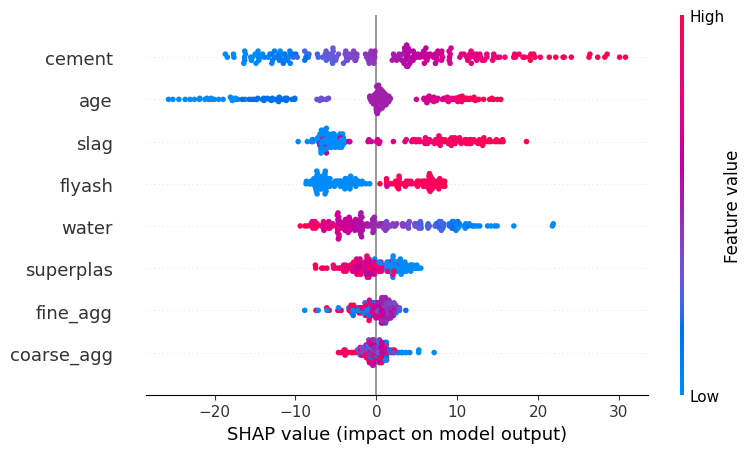

In [24]:
import shap
import pandas as pd
import numpy as np

shap_values_array = shap_values.values  # Extract SHAP values correctly
feature_names = normed_test_data.columns  # Get feature names

# Get predicted values from the model
y_pred = dnn_model.predict(normed_test_data).flatten()  
# Prepare a DataFrame for the output
shap_output_df = pd.DataFrame(normed_test_data, columns=feature_names)  # Include feature values
shap_output_df['Predicted Value'] = y_pred  # Add predicted values
for i, feature in enumerate(feature_names):
    shap_output_df[f'SHAP Value ({feature})'] = shap_values_array[:, i]  # Add SHAP values for each feature

print(shap_output_df.head())
shap_output_df.to_csv('shap_explanation_output.csv', index=False)
shap.summary_plot(shap_values, normed_test_data)


In [25]:
shap_output_df.head()

,cement,slag,flyash,water,superplas,coarse_agg,fine_agg,age,Predicted Value,SHAP Value (cement),SHAP Value (slag),SHAP Value (flyash),SHAP Value (water),SHAP Value (superplas),SHAP Value (coarse_agg),SHAP Value (fine_agg),SHAP Value (age)
0,1.613819,-1.068428,-0.912456,2.102973,-1.221546,-0.524113,-2.073599,0.122103,37.785179,19.604768,-5.135164,-5.938391,-8.032120,3.027699,0.640809,-2.135528,0.653115
1,1.613819,-1.068428,-0.912456,2.102973,-1.221546,-0.524113,-2.073599,1.779054,45.327148,19.041797,-4.811621,-6.175569,-8.829898,2.833628,0.413592,-2.254840,10.010068
2,0.976549,-1.068428,-0.912456,2.102973,-1.221546,-0.524113,-1.266151,2.417297,49.437580,11.297766,-6.181324,-5.889381,-7.942677,4.091543,1.031875,3.645853,14.283935
3,0.606318,0.997444,-0.912456,2.102973,-1.221546,-0.524113,-2.073599,1.156361,39.015736,5.943717,7.369626,-3.252395,-6.576105,1.331606,-0.805660,-7.194321,7.099277
4,-0.290939,1.223851,-0.912456,2.102973,-1.221546,-0.524113,-2.073599,1.779054,38.695652,-2.558269,12.189762,-3.383703,-7.308780,1.062380,-0.947502,-6.112983,10.654757


In [44]:
import shap
import numpy as np
import pandas as pd
def predict_and_explain(input_features):
    input_df = pd.DataFrame([input_features], columns=normed_train_data.columns)
    prediction = dnn_model.predict(input_df).flatten()[0]  # Make prediction and flatten to get scalar value
    explainer = shap.KernelExplainer(dnn_model.predict, normed_train_data)
    shap_values = explainer.shap_values(input_df)  # KernelExplainer returns a list of SHAP values
    shap_values = shap_values if isinstance(shap_values, np.ndarray) else shap_values[0]
    print(f"Predicted Concrete Strength: {prediction:.4f}")
    print("\nFeature Contributions:")
    for feature_name, shap_value in zip(normed_train_data.columns, shap_values.flatten()):  # Ensure scalar values
        print(f"{feature_name}: SHAP Value = {shap_value:.4f}")
    
    shap.force_plot(explainer.expected_value, shap_values, input_df)

# Example: Input values for each feature (you can modify these values)
input_features = {
     'cement': 540.0 ,
    'slag': 0.0,
    'flyash': 100.0,
    'water': 162.0,
    'superplas': 2.5,
    'coarse_agg': 1040.0,
    'fine_agg': 676.0,
    'age': 30
    
}

# Call the function to predict and explain
predict_and_explain(input_features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Using 824 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Predicted Concrete Strength: 16871.2969

Feature Contributions:
cement: SHAP Value = 7080.3265
slag: SHAP Value = -1.1123
flyash: SHAP Value = -1.0166
water: SHAP Value = -712.9135
superplas: SHAP Value = -5.5983
coarse_agg: SHAP Value = 6934.4632
fine_agg: SHAP Value = 3268.5716
age: SHAP Value = 273.3582


In [83]:
explainer = shap.KernelExplainer(dnn_model.predict, normed_train_data)
shap_values = explainer.shap_values(normed_test_data)
np.save('shap_values.npy', shap_values)  
# Save the trained Keras model to a file
dnn_model.save('final_concrete_strength_model.h5')


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


  0%|          | 0/206 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 6s 881us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━

In [85]:
pip install  streamlit  Pillow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import numpy as np
import shap
import pickle
from tensorflow.keras.models import load_model

# Load your trained Keras model
model = load_model('final_concrete_strength_model.h5')

explainer = shap.KernelExplainer(model.predict, normed_train_data)
shap_values = explainer.shap_values(normed_test_data)

# Save SHAP values to a .pkl file
with open('shap_values.pkl', 'wb') as file:
    pickle.dump(shap_values, file)

print("SHAP values saved to shap_values.pkl")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 0/206 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 6s 910us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 6s 912us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 7s 991us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━

In [45]:
dnn_model.save('final_concrete_strength_model.h5')

In [46]:
import pickle
from tensorflow.keras.models import load_model
with open('final_concrete_strength_model.pkl', 'wb') as file:
    pickle.dump(dnn_model, file)

In [47]:
import pickle

# Load the model from a .pkl file
with open('final_concrete_strength_model.pkl', 'rb') as file:
    dnn_model = pickle.load(file)




In [37]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('final_concrete_strength_model.h5')
with open('shap_values.pkl', 'rb') as file:
    shap_values = pickle.load(file)

print("Loaded SHAP values from shap_values.pkl")


Loaded SHAP values from shap_values.pkl


In [45]:
import lime
import lime.lime_tabular

# Assuming your normalized data and model are ready
explainer = lime.lime_tabular.LimeTabularExplainer(normed_train_data.values, 
                                                   feature_names=normed_train_data.columns, 
                                                   class_names=['Compressive Strength'],
                                                   verbose=True, mode='regression')

lime_explanation = explainer.explain_instance(normed_test_data.iloc[0].values, dnn_model.predict, num_features=5)

# Get the top 5 features from LIME
lime_values = lime_explanation.as_list()
print("\nTop LIME Features and Weights:")
print(lime_values)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 39.24113212402439
Prediction_local [34.41866807]
Right: 38.817097

Top LIME Features and Weights:
[('cement > 0.76', 20.675161094458907), ('slag <= -1.07', -11.757785648283804), ('flyash <= -0.91', -9.510388995434033), ('water > 0.49', -7.074268288884901), ('superplas <= -1.22', 2.84481778548079)]


In [48]:
my_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

dnn_model.compile(optimizer=my_optimizer, 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])


In [49]:
dnn_model.save('final_model.h5')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
                         Statistic  Value (MPa)
0                    Mean Residual     0.274361
1                  Median Residual     0.396788
2  Standard Deviation of Residuals     5.622478
3                 Minimum Residual   -24.992207
4                 Maximum Residual    22.532934


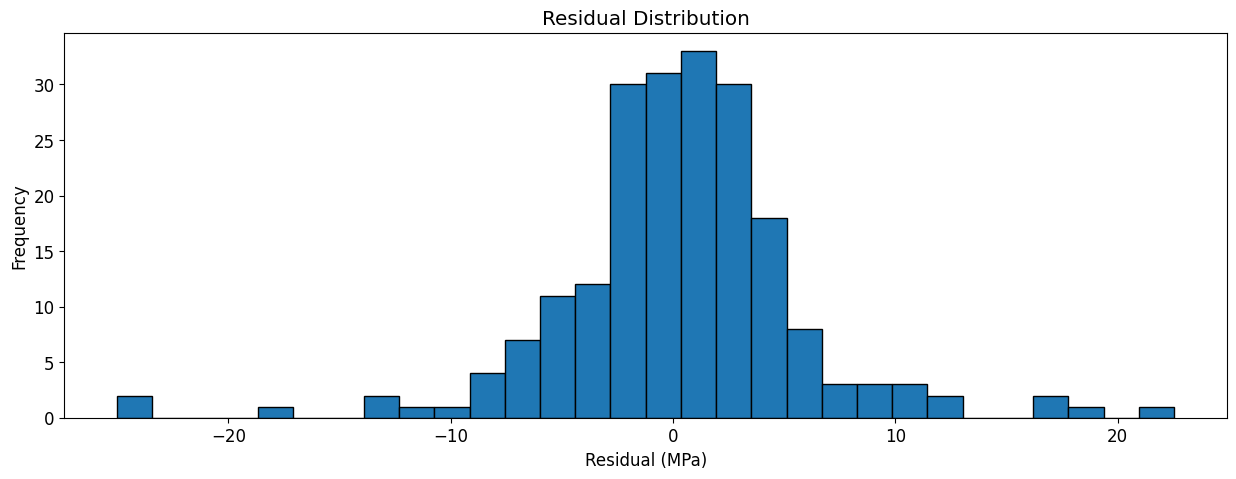

In [68]:
import numpy as np
import pandas as pd

# Assuming 'model' is your trained model, and 'normed_test_data' and 'test_labels' are your test data and labels

# Step 1: Predict using the model
predicted_values = model.predict(normed_test_data)

# Step 2: Calculate the residuals
residuals = test_labels - predicted_values.flatten()

# Step 3: Compute statistical measures of the residuals
mean_residual = np.mean(residuals)
median_residual = np.median(residuals)
std_residual = np.std(residuals)
min_residual = np.min(residuals)
max_residual = np.max(residuals) 

# Step 4: Create a table for residual statistics
residual_stats = pd.DataFrame({
    'Statistic': ['Mean Residual', 'Median Residual', 'Standard Deviation of Residuals', 'Minimum Residual','Maximum Residual'],
    'Value (MPa)': [mean_residual, median_residual, std_residual, min_residual, max_residual]
})

# Display the table
print(residual_stats)

# Optional: Visualize residuals with a histogram
import matplotlib.pyplot as plt

plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Residual Distribution')
plt.xlabel('Residual (MPa)')
plt.ylabel('Frequency')
plt.show()


In [72]:

pip install lime


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---- ----------------------------------- 30.7/275.7 kB ? eta -:--:--
     -------- ---------------------------- 61.4/275.7 kB 825.8 kB/s eta 0:00:01
     -------------- --------------------- 112.6/275.7 kB 939.4 kB/s eta 0:00:01
     ------------------------------------ - 266.2/275.7 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=ec6552eec85ea66c4f82215373627c8c49c4b0083c8d402de0f8e4eb05a042b7
  Stored in directory: c:\users\shiva\appdata\local\pip\cache\wheels\85\fa\a3\9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Note: you may need to restart the kernel to use upd


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
normed_test_data = standardise(transformed_test_data)

print(type(normed_test_data))  # Should print <class 'pandas.core.frame.DataFrame'>
print(normed_test_data.head())  # Show the first few rows of the DataFrame


<class 'pandas.core.frame.DataFrame'>
     cement      slag    flyash     water  superplas  coarse_agg  fine_agg  \
0  1.613819 -1.068428 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   
1  1.613819 -1.068428 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   
2  0.976549 -1.068428 -0.912456  2.102973  -1.221546   -0.524113 -1.266151   
3  0.606318  0.997444 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   
4 -0.290939  1.223851 -0.912456  2.102973  -1.221546   -0.524113 -2.073599   

        age  
0  0.122103  
1  1.779054  
2  2.417297  
3  1.156361  
4  1.779054  


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept 44.151570307401386
Prediction_local [36.30618331]
Right: 40.17438


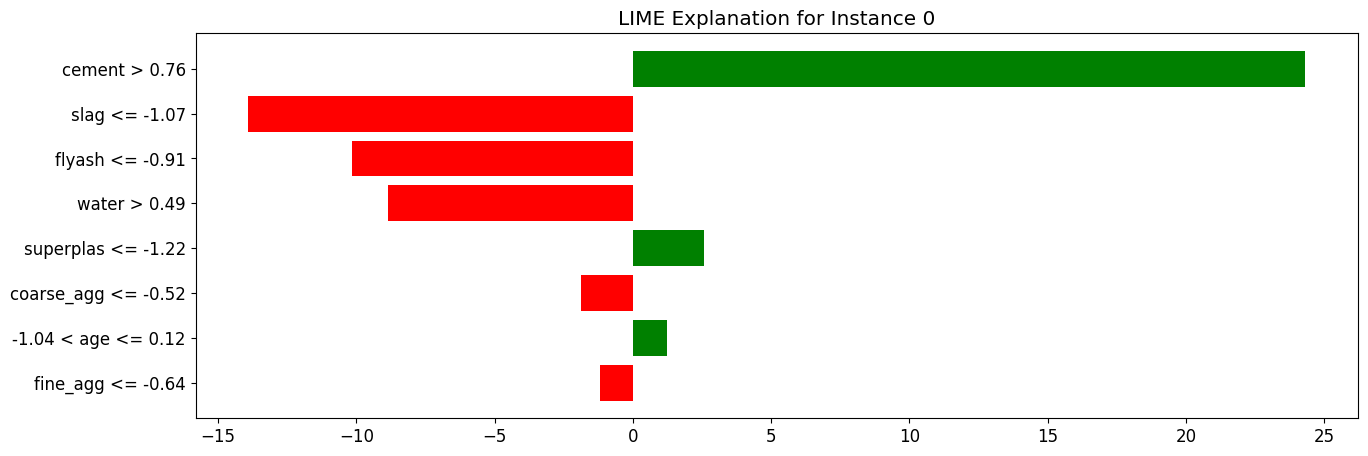

LIME Explanation (Feature Priorities):
[('cement > 0.76', 24.31468530885482), ('slag <= -1.07', -13.905826427576027), ('flyash <= -0.91', -10.14653969466595), ('water > 0.49', -8.84569460087429), ('superplas <= -1.22', 2.5542191966284826), ('coarse_agg <= -0.52', -1.863628259852663), ('-1.04 < age <= 0.12', 1.2348842793516113), ('fine_agg <= -0.64', -1.1874867988552618)]


In [27]:
import lime
import lime.lime_tabular

import numpy as np
import matplotlib.pyplot as plt

# Define the LIME explainer for the dataset
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(normed_train_data),  # Training data used for explanation
    mode='regression',  # This is a regression task
    feature_names=normed_train_data.columns,  # Column names for better interpretability
    class_names=['strength'],  # Target variable
    verbose=True,
    random_state=42
)

# Select an instance from the test dataset to explain
i = 0  # Index of the instance to explain. Change 'i' to select different instances.
exp = explainer.explain_instance(
    data_row=normed_test_data.iloc[i],  # The instance to be explained
    predict_fn=dnn_model.predict,  # The prediction function of the DNN model
    num_features=8  # Number of top features to display
)

# Display the explanation as a matplotlib figure
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {i}")
plt.show()

# Print the features with the highest priorities (impact) based on LIME
print("LIME Explanation (Feature Priorities):")
print(exp.as_list())  # Outputs the feature contributions and their weights


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept 37.64587865796284
Prediction_local [35.7676527]
Right: 38.817097
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
Intercept 36.301458100048954
Prediction_local [48.23841917]
Right: 47.88762
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 36.524635327697005
Prediction_local [48.54821739]
Right: 49.359787
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 33.37040190711597
Prediction_local [46.92118518]
Right: 38.892937
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Intercept 34.621013436080524
Prediction_local [43.46091013]
Right: 37.594154
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept 34.366527989398506
Prediction_local [44.81405565]
Right: 47.450245
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 33.97285809013945
Prediction_local [46.14155577]
Right: 52.17169
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 35.285242806629014
Prediction_local [35.11088381]
Right: 45.78022
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept 40.9715890

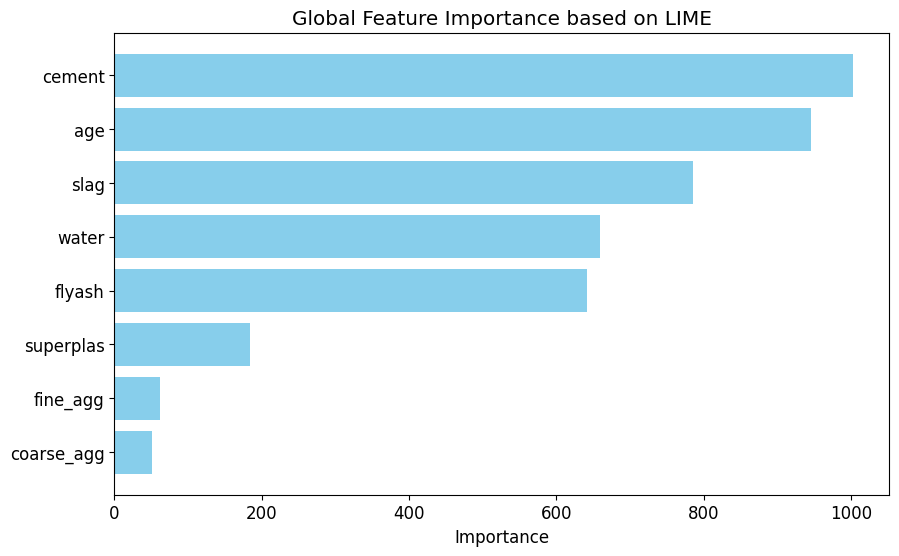

In [50]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the LIME explainer for the dataset
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(normed_train_data),  # Training data used for explanation
    mode='regression',  # This is a regression task
    feature_names=normed_train_data.columns,  # Column names for better interpretability
    class_names=['strength'],  # Target variable
    verbose=True,
    random_state=42
)

# Dictionary to accumulate feature importance across multiple instances
feature_importance = {feature: 0 for feature in normed_train_data.columns}

# Loop over multiple instances (you can define how many test instances you want to explain)
num_instances = 100  # Number of instances to explain
for i in range(num_instances):
    exp = explainer.explain_instance(
        data_row=normed_test_data.iloc[i],  # The instance to be explained
        predict_fn=dnn_model.predict,  # The prediction function of the DNN model
        num_features=8  # Number of top features to display
    )
    
    # Add the feature importances from this instance to the global dictionary
    for feature_conditional, importance in exp.as_list():
        # Split the feature_conditional string to get the actual feature name
        feature_name = feature_conditional.split(' ')[0]
        if feature_name in feature_importance:
            feature_importance[feature_name] += abs(importance)  # Take absolute value of importance

# Convert the feature importance dictionary to a DataFrame for easy sorting and display
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print("Global Feature Importance (LIME):")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Global Feature Importance based on LIME')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept -33.77100229942731
Prediction_local [287.29868232]
Right: 20997.59
Predicted Concrete Strength: 20997.5898 MPa

Feature Contributions (LIME Explanation):
age > 0.73: Contribution = 58.4054
cement > 0.76: Contribution = 53.1973
slag > 1.00: Contribution = 47.5243
coarse_agg > 0.73: Contribution = 39.3285
-0.91 < flyash <= 1.11: Contribution = 39.1556
fine_agg > 0.62: Contribution = 33.7768
superplas > 0.83: Contribution = 26.6573
water > 0.49: Contribution = 23.0244


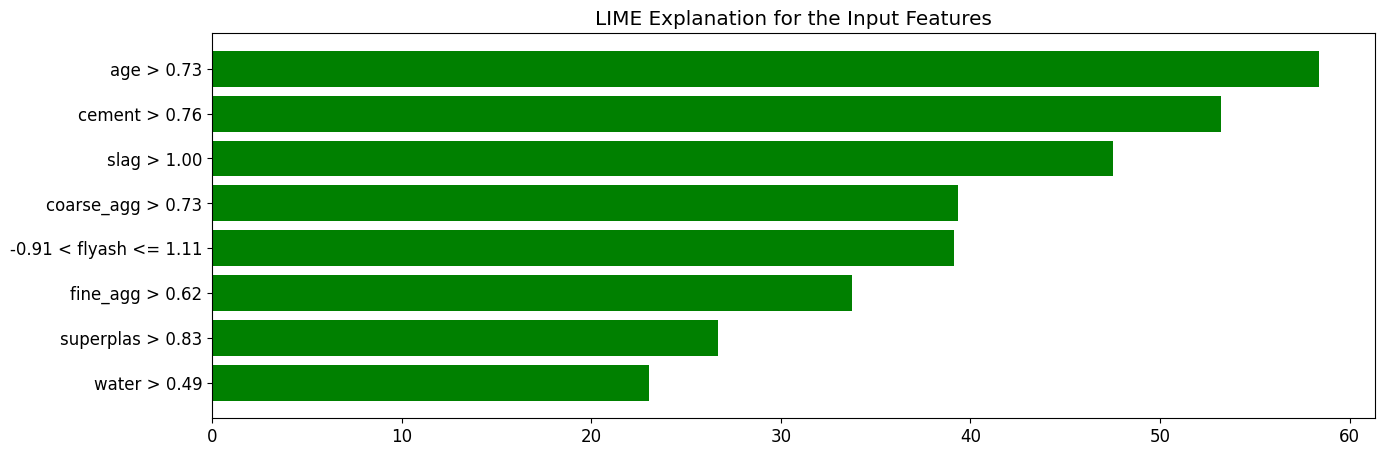

In [26]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(normed_train_data),  # Training data used for explanation
    mode='regression',  # This is a regression task
    feature_names=normed_train_data.columns,  # Column names for better interpretability
    class_names=['strength'],  # Target variable
    verbose=True,
    random_state=42
)

# Function to predict and explain the contributions of features
def predict_and_explain(input_features):
    # Convert input feature values to a DataFrame (with the same structure as your normed_train_data)
    input_df = pd.DataFrame([input_features], columns=normed_train_data.columns)
    
    # Normalize the input features using the same standardization method as the training data
    normed_input_df = standardise(input_df)

    # Make a prediction using the model
    prediction = dnn_model.predict(normed_input_df).flatten()[0]  # Flatten to get scalar value
    
    # Use LIME to explain the prediction
    exp = explainer.explain_instance(
        data_row=normed_input_df.iloc[0],  # The single instance to explain
        predict_fn=dnn_model.predict,  # The DNN model's prediction function
        num_features=8  # Number of top features to explain
    )
    
    # Display prediction
    print(f"Predicted Concrete Strength: {prediction:.4f} MPa")

    # Display feature contributions
    print("\nFeature Contributions (LIME Explanation):")
    for feature, contribution in exp.as_list():
        print(f"{feature}: Contribution = {contribution:.4f}")
    
    # Plot explanation
    fig = exp.as_pyplot_figure()
    plt.title("LIME Explanation for the Input Features")
    plt.show()

# Example: Input feature values (you can modify these based on your project)
input_features = {
    'cement': 560.0,
    'slag': 70.0,
    'flyash': 0.0,
    'water': 180.0,
    'superplas': 50.0,
    'coarse_agg': 900.0,
    'fine_agg': 800.0,
    'age': 90
}

# Call the function to predict and explain the contributions
predict_and_explain(input_features)


In [68]:
!pip install pdpbox --upgrade




Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
